In [ ]:
!pip install albumentations timm

In [ ]:
!pip install tqdm

In [ ]:
!pip install ipywidgets==7.4.2
!jupyter nbextension enable --py widgetsnbextension

In [2]:
import time
#from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
from tqdm.notebook import tqdm as tqdm
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import torch.nn as nn
import timm
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("Starting")

Starting


In [14]:
class args:
    lr = 0.0001
    epochs = 1
    batch_size = 16
    num_workers = 4
    folds = 5
    arch = 'tf_efficientnet_b2'

In [5]:
alldf = pd.read_csv("data/train.csv")
valdf = alldf[::args.folds]
trndf = alldf[~alldf.filename.isin(valdf.filename)]
tstdf = pd.read_csv('data/test.csv')
metadf = pd.read_csv("data/metadata.csv")
metadf = metadf.set_index('label')

In [6]:
print(f'File shapes -- train : {trndf.shape}, valid : {valdf.shape}, test : {tstdf.shape}')

File shapes -- train : (40672, 2), valid : (10169, 2), test : (19258, 2)


In [7]:
def trntransforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Transpose(p=0.5),
        A.RandomRotate90(p=0.5),
        ToTensorV2(),
    ])

def tsttransforms():
    return A.Compose([
        ToTensorV2(),
    ])

class BirdDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.data = df
        self.img_dir = f'./'
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        fname = self.data.iloc[idx]['filename'] + ".png"
        img_path = f'{self.img_dir}/data/{fname}'
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image = image)['image']
        image = image.float() / 255.
        label = -1 if self.mode=='test' else self.data.iloc[idx]['label']

        return image, label

In [8]:
# Define our dataset
trndataset = BirdDataset(trndf, 'train', trntransforms())
valdataset = BirdDataset(valdf, 'valid', tsttransforms())
tstdataset = BirdDataset(tstdf, 'test', tsttransforms())

Label : (39.065, 51.408]


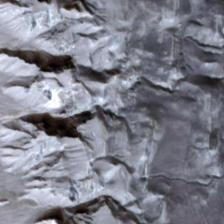

In [9]:
# Test the dataset
img, label = next(iter(trndataset))
species = metadf.loc[label]['label_name']
print(f'Label : {species}')
#Image.fromarray(img)
imgviz = (img * 255).transpose(0, 2).numpy().astype(np.uint8)
Image.fromarray(imgviz)

In [10]:
loaderargs = {'num_workers' : args.num_workers, 'batch_size':args.batch_size, 'pin_memory': False, 'drop_last': False}
trnloader = DataLoader(trndataset, shuffle = True, **loaderargs)
valloader = DataLoader(valdataset, shuffle = False, **loaderargs)
tstloader = DataLoader(tstdataset, shuffle = False, **loaderargs)

In [15]:
device = torch.device("cuda:0")
model = timm.create_model(args.arch, pretrained = True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
# Loss function
criterion = torch.nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=4)
num_epochs = args.epochs

INFO:timm.models.helpers:Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b2_aa-60c94f97.pth)


In [16]:
torch.cuda.is_available()

True

In [ ]:
since = time.time()
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    model.train()
    running_loss = 0.0
    tk0 = tqdm(trnloader, total=int(len(trnloader)))
    for step, batch in enumerate(tk0):
        inputs = batch[0].cuda().float()
        labels = batch[1].cuda().long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        tk0.set_postfix(train_loss=(running_loss / (step+1)))
    valpreds = []
    model.eval()
    last_lr = scheduler.get_last_lr()
    scheduler.step()
    running_loss = 0.0
    tkval = tqdm(valloader, total=int(len(valloader)))
    for step, batch in enumerate(tkval):
        inputs = batch[0].to(device, dtype=torch.float)
        labels = batch[1].to(device).long()
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        valpreds .append(outputs)
        running_loss += loss.item()
        tkval.set_postfix(valid_loss=(running_loss / (step+1)))
    preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
    print(f'Valid accuracy {(valdf.label.values == preds).mean():.4f}')
    print("Last learning rate " + str(last_lr))

Epoch 0/0


In [ ]:
tstpreds = []
tktst = tqdm(tstloader, total=int(len(tstloader)))
for step, batch in enumerate(tktst):
    inputs = batch[0].to(device, dtype=torch.float)
    with torch.no_grad():
        outputs = model(inputs)
        tstpreds.append(outputs)
predicted_labels = torch.cat(tstpreds).argmax(1).detach().cpu().numpy()
tstdf['label_pred'] = predicted_labels
print(f'Test accuracy {(tstdf.label.values == predicted_labels).mean():.4f}')

In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()